In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ydata_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("Microsoft_malware_dataset_min.csv")
df.head()

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_OSEdition,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,OsPlatformSubRelease,CountryIdentifier
0,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,29
1,0,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,93
2,0,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,86
3,1,0.0,0.0,Professional,0,1.0,0.0,1.0,rs4,88
4,1,0.0,0.0,Core,0,1.0,0.0,1.0,rs4,18


In [3]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HasDetections               100000 non-null  int64  
 1   Wdft_IsGamer                96585 non-null   float64
 2   Census_IsVirtualDevice      99815 non-null   float64
 3   Census_OSEdition            100000 non-null  object 
 4   Census_HasOpticalDiskDrive  100000 non-null  int64  
 5   Firewall                    98924 non-null   float64
 6   SMode                       94068 non-null   float64
 7   IsProtected                 99609 non-null   float64
 8   OsPlatformSubRelease        100000 non-null  object 
 9   CountryIdentifier           100000 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 7.6+ MB


In [4]:
# profile report
profile = ProfileReport(df, title="Microsoft Malware Dataset Profile Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Handle Missing Values

In [5]:
df.isnull().sum()

HasDetections                    0
Wdft_IsGamer                  3415
Census_IsVirtualDevice         185
Census_OSEdition                 0
Census_HasOpticalDiskDrive       0
Firewall                      1076
SMode                         5932
IsProtected                    391
OsPlatformSubRelease             0
CountryIdentifier                0
dtype: int64

In [6]:
# imputing missing values with mode as they are all binary
for col in ['Wdft_IsGamer', 'Census_IsVirtualDevice', 'Firewall', 'SMode', 'IsProtected']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
# confirm there are no more missing values
df.isna().sum()

HasDetections                 0
Wdft_IsGamer                  0
Census_IsVirtualDevice        0
Census_OSEdition              0
Census_HasOpticalDiskDrive    0
Firewall                      0
SMode                         0
IsProtected                   0
OsPlatformSubRelease          0
CountryIdentifier             0
dtype: int64

## Handle Duplicated Values

In [8]:
df.duplicated().sum()

np.int64(83886)

In [9]:
# drop duplicates
df = df.drop_duplicates()

## PART 1: Supervised Learning

### Encode Categotical Features

In [10]:
nominal_cols = ['Census_OSEdition', 'OsPlatformSubRelease']

# apply one-hot-encoding and drop the first column to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True)
df_encoded.head()

,HasDetections,Wdft_IsGamer,Census_IsVirtualDevice,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,CountryIdentifier,Census_OSEdition_Core,Census_OSEdition_CoreCountrySpecific,...,Census_OSEdition_ServerStandard,Census_OSEdition_ServerStandardEval,OsPlatformSubRelease_rs1,OsPlatformSubRelease_rs2,OsPlatformSubRelease_rs3,OsPlatformSubRelease_rs4,OsPlatformSubRelease_th1,OsPlatformSubRelease_th2,OsPlatformSubRelease_windows7,OsPlatformSubRelease_windows8.1
0,0,0.0,0.0,0,1.0,0.0,1.0,29,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0,0.0,0.0,0,1.0,0.0,1.0,93,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0,0.0,0.0,0,1.0,0.0,1.0,86,True,False,...,False,False,False,False,False,True,False,False,False,False
3,1,0.0,0.0,0,1.0,0.0,1.0,88,False,False,...,False,False,False,False,False,True,False,False,False,False
4,1,0.0,0.0,0,1.0,0.0,1.0,18,True,False,...,False,False,False,False,False,True,False,False,False,False


### Preparing Dataset For Modeling

In [11]:
# separate features and the target variable
X = df_encoded.drop('HasDetections', axis=1)
y = df_encoded['HasDetections']

In [12]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set', X_train.shape)
print('Test set', y_train.shape)

Train set (12891, 33)
Test set (12891,)


In [13]:
X_train.head()

,Wdft_IsGamer,Census_IsVirtualDevice,Census_HasOpticalDiskDrive,Firewall,SMode,IsProtected,CountryIdentifier,Census_OSEdition_Core,Census_OSEdition_CoreCountrySpecific,Census_OSEdition_CoreN,...,Census_OSEdition_ServerStandard,Census_OSEdition_ServerStandardEval,OsPlatformSubRelease_rs1,OsPlatformSubRelease_rs2,OsPlatformSubRelease_rs3,OsPlatformSubRelease_rs4,OsPlatformSubRelease_th1,OsPlatformSubRelease_th2,OsPlatformSubRelease_windows7,OsPlatformSubRelease_windows8.1
11820,1.0,0.0,1,0.0,0.0,1.0,7,False,False,False,...,False,False,False,False,False,True,False,False,False,False
97712,0.0,0.0,1,1.0,0.0,1.0,41,False,False,False,...,False,False,True,False,False,False,False,False,False,False
73565,0.0,0.0,0,1.0,0.0,1.0,142,False,False,False,...,False,False,False,False,False,False,False,True,False,False
22953,1.0,0.0,1,1.0,0.0,1.0,12,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4187,1.0,0.0,0,1.0,0.0,1.0,159,True,False,False,...,False,False,False,False,True,False,False,False,False,False


In [14]:
print(df['HasDetections'].value_counts())

HasDetections
0    8549
1    7565
Name: count, dtype: int64


### Decision Tree and, ROC Curve

In [15]:
# initialize and train the decision tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [16]:
# predict probabilities for ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

In [17]:
# compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1]) 
roc_auc = auc(fpr, tpr)

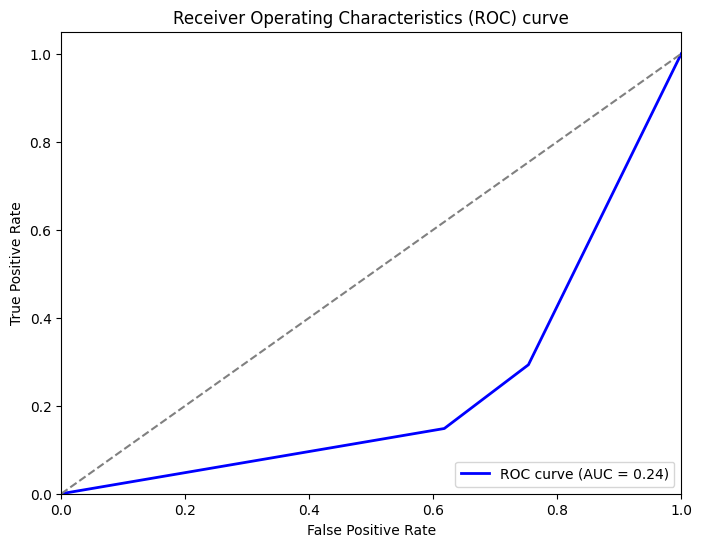

In [18]:
# plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics (ROC) curve')
plt.legend(loc='lower right')
plt.show()

### Improve Model Performance by Changing the Model Hyperparameters

In [19]:
# define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],  # Deeper trees to capture patterns
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]  # Reduce overfitting
}

In [20]:
# initialize base model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [21]:
# perform grid search
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [22]:
# best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [23]:
# compute ROC curve with best model
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

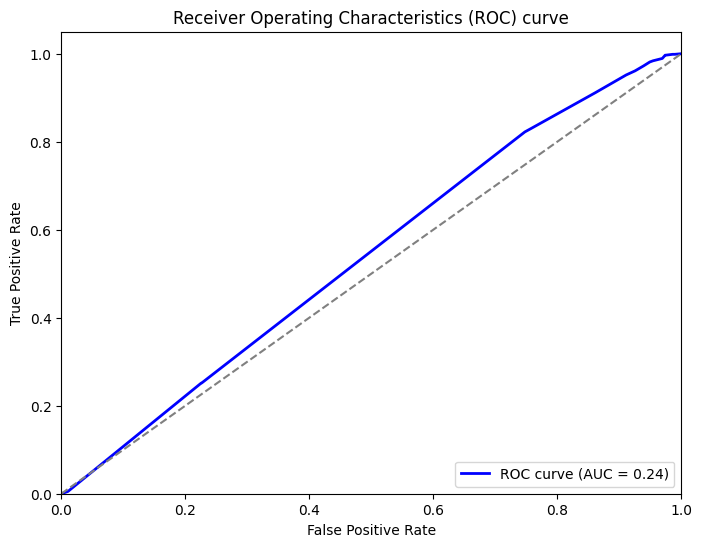

In [24]:
# plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics (ROC) curve')
plt.legend(loc='lower right')
plt.show()

AUC value is 0.24 which is very low. Worse than random guessing that is 0.5.

### Trying to improve the model using randomized search

In [25]:
# Define hyperparameter distribution
param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 10, 2),
    'criterion': ['gini', 'entropy']
}

In [26]:
# Initialize base model
dt = DecisionTreeClassifier(random_state=42)


In [27]:

# Perform randomized search
random_search = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, None],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
                   random_state=42, scoring='roc_auc')

In [28]:

# Best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(9), 'max_depth': 5, 'criterion': 'gini'}


In [29]:

# Compute ROC curve with best model
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)


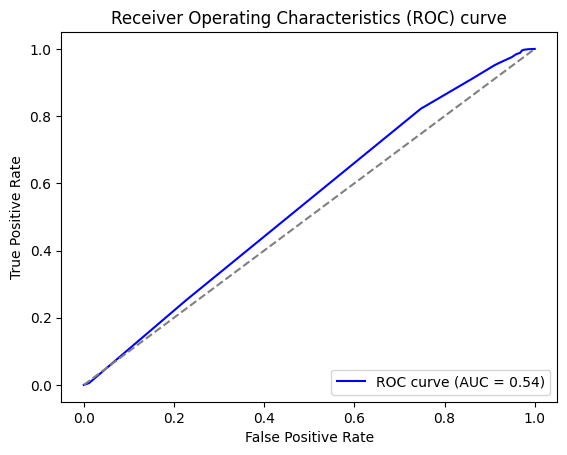

In [30]:

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics (ROC) curve')
plt.legend(loc='lower right')
plt.show()


- Model has improved from an auc of 0.24 to 0.54

### Trying random forest to further improve the model

In [31]:
# Initialize the Random Forest model with balanced class weights to handle class imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')


In [32]:
# Define the hyperparameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],              # Maximum depth of each tree; None means no limit
    'min_samples_split': np.arange(2, 10, 2),      # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 5),           # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']     # Number of features to consider when looking for the best split
}


In [33]:
# Setup RandomizedSearchCV to explore hyperparameters efficiently
rf_random = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=20, 
                               cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
# Fit the randomized search on training data
rf_random.fit(X_train, y_train)

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 436

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='roc_auc')

In [34]:
# Extract the best model from the randomized search
best_rf = rf_random.best_estimator_
print("Best RF Parameters:", rf_random.best_params_)

# Compute predicted probabilities for the positive class using the best Random Forest model
rf_y_probs = best_rf.predict_proba(X_test)[:, 1]

Best RF Parameters: {'n_estimators': 50, 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(4), 'max_features': 'sqrt', 'max_depth': 5}


In [35]:
# Calculate the false positive rate (fpr) and true positive rate (tpr) for the ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_probs)
# Compute the Area Under the Curve (AUC) for the ROC
roc_auc_value = auc(rf_fpr, rf_tpr)

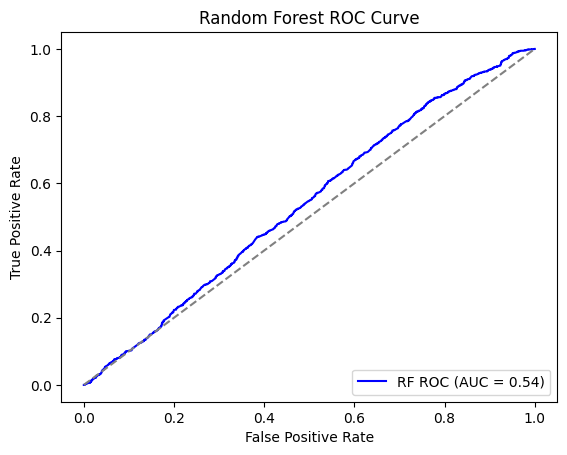

In [37]:
# Plot the ROC curve for the Random Forest model
plt.figure()
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'RF ROC (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

- Random Forest model is performing similarly to the Decision Tree randomized search model with an AUC of 0.54.

In [38]:
# Feature importance analysis for Random Forest
# Get feature importances and create a DataFrame for better visualization
importances = best_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}) \
                           .sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", feature_importance_df)

Random Forest Feature Importances:
                                     Feature  Importance
1                    Census_IsVirtualDevice    0.319848
5                               IsProtected    0.154535
6                         CountryIdentifier    0.129114
28                 OsPlatformSubRelease_rs4    0.043402
11               Census_OSEdition_Education    0.037577
0                              Wdft_IsGamer    0.032451
4                                     SMode    0.032404
7                     Census_OSEdition_Core    0.030009
2                Census_HasOpticalDiskDrive    0.024706
23          Census_OSEdition_ServerStandard    0.023654
20           Census_OSEdition_ProfessionalN    0.020573
3                                  Firewall    0.019745
30                 OsPlatformSubRelease_th2    0.016045
8      Census_OSEdition_CoreCountrySpecific    0.014240
17            Census_OSEdition_Professional    0.014076
10      Census_OSEdition_CoreSingleLanguage    0.012800
26          

- Model performance is poor and does not seem to be improving with tuning hyperparameters or changing to a different algorithm

## PART 2: Unsupervised Learning

In [40]:
# drop the targert variable
X_unlabeled = df.drop(columns=['HasDetections'])

In [41]:
# encode categorical columns
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['Census_OSEdition', 'OsPlatformSubRelease'])

In [42]:
# Standardize the features
scaler_unsup = StandardScaler()
X_scaled_unsup = scaler_unsup.fit_transform(X_unlabeled)

In [43]:
# Find the Optimal Number of Clusters using the Elbow Method

wcss_unsup = [] # Within-Cluster Sum of Squares (WCSS)
k_range_unsup = range(1, 11)  # Test K=1 to 10

for k in k_range_unsup:
    kmeans_unsup = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_unsup.fit(X_scaled_unsup)
    wcss_unsup.append(kmeans_unsup.inertia_)


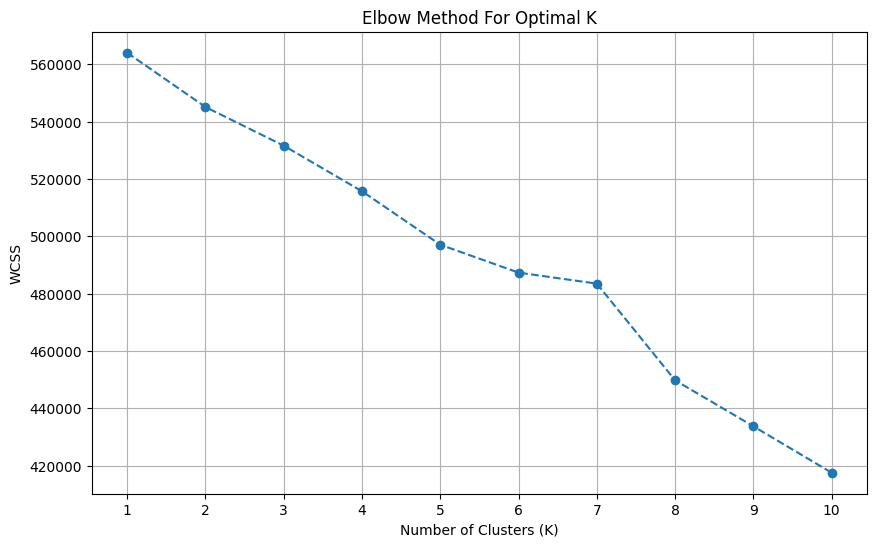

In [44]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range_unsup, wcss_unsup, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal K')
plt.xticks(k_range_unsup)
plt.grid(True)
plt.show()

- From the Elbow plot, the Within-Cluster Sum of Squares (WCSS) is steadily decreasing as 𝑘 increases, but there’s no extremely sharp “elbow.”
- The biggest drop appears between 5 and 6 clusters, which often indicates a potential “sweet spot.”

In [45]:
# Apply K-Means Clustering with the Optimal K
optimal_k_unsup = 5

# Train with new variable names
kmeans_final_unsup = KMeans(n_clusters=optimal_k_unsup, init='k-means++', random_state=42)
clusters_unsup = kmeans_final_unsup.fit_predict(X_scaled_unsup)

# Add clusters to DataFrame (new column name)
df['Cluster_Unsupervised'] = clusters_unsup

C:\Users\Hp\AppData\Local\Temp\ipykernel_10212\4152482035.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_Unsupervised'] = clusters_unsup


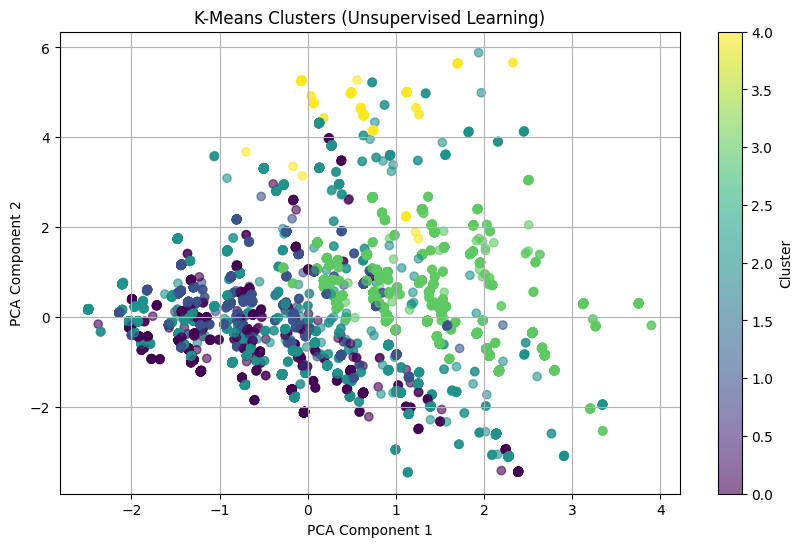

In [46]:
# Visualize Clusters Using PCA
# Reduce dimensions to 2 for visualization
pca_unsup = PCA(n_components=2, random_state=42)
X_pca_unsup = pca_unsup.fit_transform(X_scaled_unsup)

plt.figure(figsize=(10, 6))
scatter_unsup = plt.scatter(X_pca_unsup[:, 0], X_pca_unsup[:, 1], c=clusters_unsup, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (Unsupervised Learning)')
plt.colorbar(scatter_unsup, label='Cluster')
plt.grid(True)
plt.show()